## Imports

In [1]:
import pandas as pd
import glob
import datasets
import numpy as np
import matplotlib.pyplot as plt

## Load Data

In [2]:
wiki_data = pd.read_csv("../../data/wikidata/wikidata-property-list.csv")
wiki_data = wiki_data[["Title", "ID", "Datatype", "Description"]]

In [3]:
code_to_lang_dict = {
    "bg": "Bulgarian",
    "ca": "Catalan",
    "cs": "Czech",
    "da": "Danish",
    "de": "German",
    "en": "English",
    "es": "Spanish",
    "fr": "French",
    "hr": "Croatian",
    "hu": "Hungarian",
    "it": "Italian",
    "nl": "Dutch",
    "pl": "Polish",
    "pt": "Portuguese",
    "ro": "Romanian",
    "ru": "Russian",
    "sl": "Slovenian",
    "sr": "Serbian",
    "sv": "Swedish",
    "uk": "Ukrainian",
}

In [4]:
lang_to_code_dict = {v: k for k, v in code_to_lang_dict.items()}

In [5]:
results_dict = {}
results_dict["language"] = []
results_dict["relation"] = []
results_dict["percentage change"] = []
results_dict["new ratio of rows"] = []
results_dict["old ratio of rows"] = []

hf_df = datasets.load_dataset("CalibraGPT/Fact-Completion")
file_names = glob.glob("../../data/result_logs/llama-30b/error-analysis/*.csv")

# confirm grabbing data correctly against LLaMa figure
# uncomment print statement at end of for loop to see
results_dfs = []
count = 0
for file in file_names:
    language = file.split(".csv")[0].split("-")[-1].capitalize()
    error_df = pd.read_csv(file)
    full_hf_df = hf_df[file.split(".csv")[0].split("-")[-1].capitalize()]
    full_hf_df = full_hf_df.to_pandas()

    # stem is in both
    # dataset id is in both
    # to see if the model got something wrong, see if the dataset id in the full df is in the error
    error_ids = list(error_df["dataset_id"])
    correct = []
    counts = []
    relation_names = []
    for row in full_hf_df.iterrows():
        # track counts
        count += 1
        counts.append(count)
        # track errors
        correct.append(False) if row[1]["dataset_id"] in error_ids else correct.append(
            True
        )
        # track relation titles
        relation_id = int(row[1].relation[1:])
        relation_title = list(wiki_data[wiki_data["ID"] == relation_id]["Title"])[0]
        relation_names.append(relation_title)

    # append result to full df
    full_hf_df["correct"] = correct
    # append language to full df
    full_hf_df["language"] = [language] * full_hf_df.shape[0]
    # append language code to full df
    lang_code = lang_to_code_dict[language]
    full_hf_df["lang_code"] = [lang_code] * full_hf_df.shape[0]
    # append relation title to full df
    full_hf_df["relation_title"] = relation_names
    # also append an arbitrary id to have unique val for each row
    full_hf_df["analysis_id"] = counts

    results_dfs.append(full_hf_df)

results_df = pd.concat(results_dfs)
assert results_df.shape[0] == count

Found cached dataset parquet (/Users/ashbhat/.cache/huggingface/datasets/CalibraGPT___parquet/CalibraGPT--Fact-Completion-24a24a1e4bf6e4a8/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/20 [00:00<?, ?it/s]

## Explore Data

In [6]:
results_df.head()

,dataset_id,stem,true,false,relation,subject,object,correct,language,lang_code,relation_title,analysis_id
0,calinet_8922,Приус производи,Тоиота,Хонда,P176,Приус,Тоиота,True,Serbian,sr,manufacturer,1
1,rome_5025,Сундар Пицхаи ради за,Гоогле,Аппле,P108,Сундар Пицхаи,Гоогле,False,Serbian,sr,employer,2
2,rome_21333,"Главни град Народне Републике Кине,",Пекинг,Кабул,P36,Народна Република Кина,Пекинг,True,Serbian,sr,capital,3
3,rome_8738,У Синт Мартену разумеју,холандски,дански,P37,Синт Маартен,холандски,True,Serbian,sr,official language,4
4,rome_8783,Хаас Хоусе се налази у месту,Беч,Алберта,P131,Хаас Хоусе,Беч,True,Serbian,sr,is in the administrative territorial entity,5


In [7]:
# average number of times a dataset_id gets shared across langs?
# 11.5
np.mean(results_df["dataset_id"].value_counts())

11.546545288337015

<AxesSubplot:title={'center':'Average Dataset ID usage'}, ylabel='Frequency'>

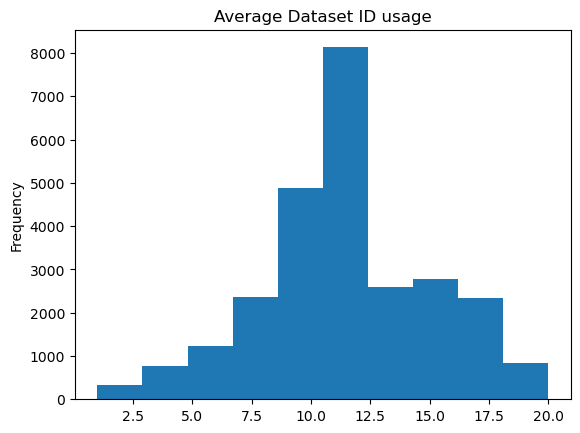

In [8]:
# hist of our usage
results_df["dataset_id"].value_counts().plot(
    kind="hist", title="Average Dataset ID usage"
)

how many dataset_id's get used across all 20 langs?

In [9]:
np.count_nonzero(results_df["dataset_id"].value_counts().values == 20)

214

how many dataset_id's get used across only 1 lang?

In [10]:
np.count_nonzero(results_df["dataset_id"].value_counts().values == 1)

77

our prius fact appears in 15 cuts -- *if* you don't take into account translations

In [11]:
results_df[results_df["object"] == "Prius"].shape[0]

0

look at all the versions of our prius fact, which appears in *16* cuts, when you take into account that its translated in serbian differently than the romanized form.

In [12]:
results_df[results_df["dataset_id"] == "calinet_8922"].shape[0]

16

## More Cleanup to Ensure that we have access to objects across langs

In [13]:
# mapping between dataset id and the english form of a object
dataset_id_to_eng_object = {}
for row in results_df.iterrows():
    if row[1].language == "English":
        if row[1].dataset_id not in dataset_id_to_eng_object:
            dataset_id_to_eng_object[row[1].dataset_id] = row[1].object

In [14]:
# put in an id and get the english object back
dataset_id_to_eng_object["rome_21844"]

'soccer'

In [15]:
objects = {}
for row in results_df.iterrows():
    # gather helpful row level data
    # the object
    object = row[1].object
    # whether the model got it right
    val = row[1].correct
    # the dataset id
    dataset_id = row[1].dataset_id
    # the english version of the object
    english_object = dataset_id_to_eng_object[dataset_id]

    # commit it to our tracking dict
    if english_object not in objects:
        objects[english_object] = {
            "correct": 0,
            "incorrect": 0,
            "langs": {},
            "alternate_forms": {},
            "dataset_ids": set(),
        }

    # counter of correct/incorrect for that object
    if val:
        objects[english_object]["correct"] += 1
    else:
        objects[english_object]["incorrect"] += 1

    # track language
    lang = row[1].lang_code

    if lang not in objects[english_object]["langs"]:
        objects[english_object]["langs"][lang] = 1

    else:
        objects[english_object]["langs"][lang] += 1

    # track any alternate forms
    objects[english_object]["alternate_forms"][lang] = object

    objects[english_object]["dataset_ids"].add(dataset_id)

In [16]:
object_names = []
correct = []
incorrect = []
total = []
pct = []
langs = []
num_langs = []
alternate_forms = []
dataset_ids = []
for k, v in objects.items():
    object_names.append(k)
    # track # of times object is used in a correct statement, incorrect, and pct accuracy
    correct.append(v["correct"])
    incorrect.append(v["incorrect"])
    total.append(int(v["correct"]) + int(v["incorrect"]))
    pct.append(int(v["correct"]) / (int(v["correct"]) + int(v["incorrect"])))
    # track # of languages the object is used in
    langs.append(v["langs"])
    num_langs.append(len(v["langs"]))
    alternate_forms.append(v["alternate_forms"])
    # track dataset ids its used in
    dataset_ids.append(list(v["dataset_ids"]))
    # sanity check
    assert int(v["correct"]) + int(v["incorrect"]) == sum(v["langs"].values())

In [17]:
# the average object appears in ~12 langs
# (remember that this will max out at 20.)
np.mean(num_langs)

14.345872801082544

In [18]:
object_analysis_df = pd.DataFrame(
    {
        "object": object_names,
        "num_correct": correct,
        "num_incorrect": incorrect,
        "total_usages": total,
        "percent_accuracy": pct,
        "languages": langs,
        "num_languages": num_langs,
        "alternate_forms": alternate_forms,
        "dataset_ids": dataset_ids,
        
    }
)

In [19]:
object_analysis_df.head(2)

,object,num_correct,num_incorrect,total_usages,percent_accuracy,languages,num_languages,alternate_forms,dataset_ids
0,Toyota,402,25,427,0.941452,"{'sr': 16, 'uk': 27, 'nl': 27, 'sv': 27, 'hu':...",20,"{'sr': 'Тоиота', 'uk': 'Toyota', 'nl': 'Toyota...","[rome_14380, calinet_8922, rome_19947, calinet..."
1,Google,768,68,836,0.918660,"{'sr': 31, 'uk': 45, 'nl': 47, 'sv': 51, 'hu':...",20,"{'sr': 'Гоогле', 'uk': 'Google', 'nl': 'Google...","[rome_11840, rome_13264, rome_2080, rome_11581..."


In [104]:
# remove multi token objects
object_analysis_df = object_analysis_df[~object_analysis_df['object'].str.contains(' ')]

## Most Correct and Incorrect by Raw Count

### Most Correct

top 10 most correct (by raw count)

In [157]:
object_analysis_df.sort_values(by="num_correct", ascending=False)[:10]

,object,num_correct,num_incorrect,total_usages,percent_accuracy,languages,num_languages,alternate_forms,dataset_ids
30,French,9775,1903,11678,0.837044,"{'sr': 446, 'uk': 351, 'nl': 992, 'sv': 708, '...",20,"{'sr': 'Француски', 'uk': 'французька', 'nl': ...","[rome_11068, rome_14803, rome_19154, rome_2009..."
168,London,6805,242,7047,0.965659,"{'sr': 6, 'uk': 11, 'nl': 598, 'sv': 605, 'hu'...",20,"{'sr': 'Лондон', 'uk': 'Лондон', 'nl': 'Londen...","[calinet_6550, rome_11933, rome_2630, rome_753..."
195,English,6671,1562,8233,0.810276,"{'sr': 5, 'uk': 364, 'nl': 761, 'sv': 40, 'hu'...",20,"{'sr': 'енглески језик', 'uk': 'англійська', '...","[rome_18861, rome_15508, calinet_3140, rome_15..."
177,jazz,6251,606,6857,0.911623,"{'sr': 13, 'uk': 212, 'nl': 402, 'sv': 549, 'h...",20,"{'sr': 'јазз', 'uk': 'джаз', 'nl': 'jazz', 'sv...","[rome_1690, rome_14937, rome_10661, rome_16667..."
45,Antarctica,4778,1375,6153,0.776532,"{'sr': 90, 'uk': 148, 'nl': 659, 'sv': 534, 'h...",20,"{'sr': 'Антарктика', 'uk': 'Антарктида', 'nl':...","[rome_4548, rome_20768, rome_5996, rome_1990, ..."
178,NBC,4119,676,4795,0.859020,"{'sr': 9, 'uk': 291, 'nl': 303, 'sv': 307, 'hu...",20,"{'sr': 'НБЦ', 'uk': 'NBC', 'nl': 'NBC', 'sv': ...","[rome_5952, rome_19815, rome_5084, rome_147, r..."
221,Paris,4066,172,4238,0.959415,"{'sr': 9, 'uk': 29, 'nl': 351, 'sv': 355, 'hu'...",20,"{'sr': 'Париз', 'uk': 'Париж', 'nl': 'Parijs',...","[rome_16464, rome_18791, rome_16992, rome_1859..."
28,actor,3640,572,4212,0.864198,"{'sr': 231, 'uk': 136, 'nl': 291, 'sv': 299, '...",20,"{'sr': 'глумац', 'uk': 'актор', 'nl': 'acteur'...","[rome_20433, rome_11140, rome_114, rome_21206,..."
26,BBC,3560,512,4072,0.874263,"{'sr': 74, 'uk': 203, 'nl': 225, 'sv': 257, 'h...",20,"{'sr': 'ББЦ', 'uk': 'BBC', 'nl': 'BBC', 'sv': ...","[rome_20480, rome_16280, rome_11659, rome_1875..."
25,Microsoft,3280,205,3485,0.941176,"{'sr': 143, 'uk': 196, 'nl': 204, 'sv': 208, '...",20,"{'sr': 'Мицрософт', 'uk': 'Microsoft', 'nl': '...","[rome_16381, rome_18233, rome_10257, rome_1936..."


### Most Incorrect

top 10 most incorrect (by raw count)

In [158]:
object_analysis_df.sort_values(by="num_incorrect", ascending=False)[:10]

,object,num_correct,num_incorrect,total_usages,percent_accuracy,languages,num_languages,alternate_forms,dataset_ids
30,French,9775,1903,11678,0.837044,"{'sr': 446, 'uk': 351, 'nl': 992, 'sv': 708, '...",20,"{'sr': 'Француски', 'uk': 'французька', 'nl': ...","[rome_11068, rome_14803, rome_19154, rome_2009..."
195,English,6671,1562,8233,0.810276,"{'sr': 5, 'uk': 364, 'nl': 761, 'sv': 40, 'hu'...",20,"{'sr': 'енглески језик', 'uk': 'англійська', '...","[rome_18861, rome_15508, calinet_3140, rome_15..."
105,CBS,2568,1479,4047,0.634544,"{'sr': 15, 'uk': 251, 'nl': 254, 'sv': 260, 'h...",20,"{'sr': 'ЦБС', 'uk': 'CBS', 'nl': 'CBS', 'sv': ...","[rome_14071, rome_19337, calinet_4614, rome_21..."
45,Antarctica,4778,1375,6153,0.776532,"{'sr': 90, 'uk': 148, 'nl': 659, 'sv': 534, 'h...",20,"{'sr': 'Антарктика', 'uk': 'Антарктида', 'nl':...","[rome_4548, rome_20768, rome_5996, rome_1990, ..."
21,politician,1007,1028,2035,0.494840,"{'sr': 125, 'uk': 72, 'nl': 132, 'sv': 139, 'h...",20,"{'sr': 'политичар', 'uk': 'політик', 'nl': 'po...","[rome_13547, rome_12064, rome_20522, calinet_5..."
83,Russian,3178,833,4011,0.792321,"{'sr': 172, 'uk': 2, 'nl': 296, 'sv': 251, 'hu...",20,"{'sr': 'Руски', 'uk': 'російський', 'nl': 'Rus...","[calinet_3269, rome_14666, rome_3044, rome_171..."
822,American,686,828,1514,0.453104,"{'sr': 1, 'nl': 260, 'sv': 30, 'hu': 3, 'ca': ...",17,"{'sr': 'Американац', 'nl': 'Amerikaans', 'sv':...","[calinet_3928, calinet_3687, calinet_3641, cal..."
178,NBC,4119,676,4795,0.859020,"{'sr': 9, 'uk': 291, 'nl': 303, 'sv': 307, 'hu...",20,"{'sr': 'НБЦ', 'uk': 'NBC', 'nl': 'NBC', 'sv': ...","[rome_5952, rome_19815, rome_5084, rome_147, r..."
58,opera,838,672,1510,0.554967,"{'sr': 7, 'uk': 28, 'nl': 92, 'sv': 159, 'hu':...",20,"{'sr': 'опера', 'uk': 'опера', 'nl': 'opera', ...","[rome_16892, rome_7230, rome_16198, rome_17875..."
1068,midfielder,2819,628,3447,0.817813,"{'sr': 1, 'uk': 64, 'nl': 322, 'sv': 259, 'hu'...",20,"{'sr': 'midfielder', 'uk': 'півзахисник', 'nl'...","[rome_18911, rome_19967, rome_3440, rome_4879,..."


In [194]:
print(object_analysis_df.sort_values(by=["total_usages","num_incorrect"], ascending=False)['object'][:80].to_list())

['French', 'English', 'London', 'jazz', 'Antarctica', 'NBC', 'Paris', 'actor', 'BBC', 'CBS', 'Russian', 'Microsoft', 'midfielder', 'Spanish', 'Italian', 'Apple', 'Berlin', 'piano', 'Japan', 'bishop', 'Rome', 'Finnish', 'politician', 'Canada', 'India', 'Germany', 'quarterback', 'Dutch', 'guitar', 'Swedish', 'Chicago', 'American', 'opera', 'Moscow', 'Vienna', 'France', 'Tamil', 'IBM', 'MTV', 'composer', 'Australia', 'Boston', 'Toronto', 'Philadelphia', 'Italy', 'poet', 'Hindi', 'Stockholm', 'Europe', 'Seattle', 'HBO', 'violin', 'Oslo', 'goaltender', 'Tokyo', 'mathematics', 'pope', 'physics', 'Amsterdam', 'Google', 'Sweden', 'Montreal', 'linebacker', 'Munich', 'Hebrew', 'ABC', 'Milan', 'Madrid', 'Nintendo', 'Poland', 'Asia', 'Jerusalem', 'journalist', 'Sony', 'Florence', 'Netherlands', 'sitcom', 'ESPN', 'Venice', 'Belgium']


<AxesSubplot:title={'center':'Average Accuracy per object'}, ylabel='Frequency'>

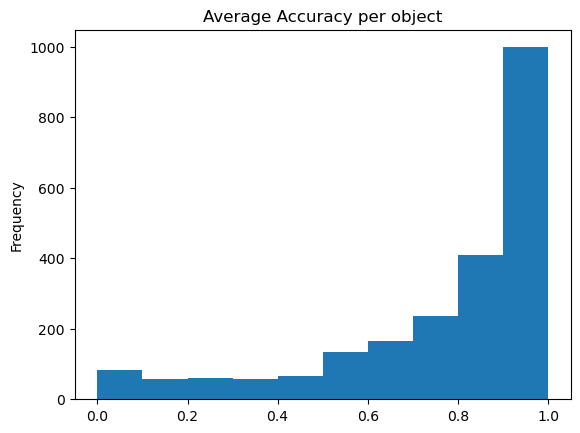

In [159]:
object_analysis_df["percent_accuracy"].plot(
    kind="hist", title="Average Accuracy per object"
)

## Most Correct and Incorrect by Percent (at least 10 usages)

there are 414 objects that were used more than 10 times and always correct!

In [160]:
len(
    object_analysis_df[
        (object_analysis_df["total_usages"] >= 10)
        & (object_analysis_df["percent_accuracy"] == 1.0)
    ]
)

414

and they comprise just 7510 of our corrects.

In [161]:
sum(
    object_analysis_df[
        (object_analysis_df["total_usages"] >= 10)
        & (object_analysis_df["percent_accuracy"] == 1.0)
    ]["total_usages"]
)

7510

there were just 32 objects that were consistently bad

In [162]:
len(
    object_analysis_df[
        (object_analysis_df["total_usages"] >= 10)
        & (object_analysis_df["percent_accuracy"] == 0.0)
    ]
)

32

and they comprise just 459 of our incorrect

In [163]:
sum(
    object_analysis_df[
        (object_analysis_df["total_usages"] >= 10)
        & (object_analysis_df["percent_accuracy"] == 0.0)
    ]["total_usages"]
)

459

subset of some of the 32 objects bad objects

In [164]:
print(object_analysis_df[
    (object_analysis_df["total_usages"] >= 10)
    & (object_analysis_df["percent_accuracy"] == 0.0)
].sort_values('total_usages',ascending=False)['object'].to_list())

['北京', 'Sujiatun', 'neoclassical', 'Paccar', '0verflow', 'Dynamix', 'RTL5', 'اردو', 'Televisa', 'CDC', 'KTTV', 'Meyrin', 'Asianet', 'Rumpler', 'Teplitz', 'Alvorada', 'М.', 'Siegburg', 'Letterkenny', 'Tommerup', 'Gorinchem', 'Spokane', 'Hermannsburg', 'Messina', 'Mari', 'Bauhinia', 'Fairfax', 'Neckar', 'Raymond', 'ARIN', 'Alexandra', 'Jasper']


## Most Correct and Incorrect by Percent (no usage minimum)

how many objects do we always get right?

In [113]:
len(object_analysis_df[object_analysis_df["percent_accuracy"] == 1.0])

497

In [114]:
object_analysis_df[object_analysis_df["percent_accuracy"] == 1.0].head()

,object,num_correct,num_incorrect,total_usages,percent_accuracy,languages,num_languages,alternate_forms,dataset_ids
34,Karelia,18,0,18,1.0,"{'sr': 1, 'uk': 1, 'nl': 1, 'sv': 1, 'ca': 1, ...",18,"{'sr': 'Карелиа', 'uk': 'Карелія', 'nl': 'Kare...",[calinet_5784]
85,CBM,18,0,18,1.0,"{'sr': 1, 'uk': 1, 'nl': 1, 'sv': 1, 'ca': 1, ...",18,"{'sr': 'ЦБМ', 'uk': 'CBM', 'nl': 'CBM', 'sv': ...",[calinet_8691]
99,DMG,18,0,18,1.0,"{'sr': 1, 'uk': 1, 'nl': 1, 'sv': 1, 'ca': 1, ...",18,"{'sr': 'ДМГ', 'uk': 'DMG', 'nl': 'DMG', 'sv': ...",[calinet_8759]
102,Madagascar,63,0,63,1.0,"{'sr': 1, 'uk': 3, 'nl': 1, 'sv': 5, 'hu': 1, ...",19,"{'sr': 'Мадагасцар', 'uk': 'Мадагаскар', 'nl':...","[rome_8058, calinet_5639, rome_21464, rome_210..."
156,Navarra,19,0,19,1.0,"{'sr': 1, 'uk': 1, 'nl': 1, 'sv': 1, 'hu': 1, ...",19,"{'sr': 'Наварра', 'uk': 'Наварра', 'nl': 'Nava...",[calinet_5960]


In [115]:
dataset_id_to_eng_object['calinet_5784']

'Karelia'

how many objects do we always get wrong?

In [116]:
len(object_analysis_df[object_analysis_df["percent_accuracy"] == 0.0])

36

In [117]:
object_analysis_df[object_analysis_df["percent_accuracy"] == 0.0].sort_values('num_incorrect',ascending=False).head()

,object,num_correct,num_incorrect,total_usages,percent_accuracy,languages,num_languages,alternate_forms,dataset_ids
496,北京,0,20,20,0.0,"{'sr': 1, 'uk': 1, 'nl': 1, 'sv': 1, 'hu': 1, ...",20,"{'sr': '北京', 'uk': '北京', 'nl': '北京', 'sv': '北京...",[calinet_2782]
709,Sujiatun,0,20,20,0.0,"{'sr': 1, 'uk': 1, 'nl': 1, 'sv': 1, 'hu': 1, ...",20,"{'sr': 'Sujiatun', 'uk': 'Sujiatun', 'nl': 'Su...",[calinet_692]
1226,neoclassical,0,20,20,0.0,"{'sr': 1, 'uk': 1, 'nl': 1, 'sv': 1, 'hu': 1, ...",20,"{'sr': 'неокласицистички', 'uk': 'неокласичний...",[calinet_8281]
783,Paccar,0,19,19,0.0,"{'sr': 1, 'uk': 1, 'nl': 1, 'sv': 1, 'ca': 1, ...",19,"{'sr': 'Паццар', 'uk': 'Paccar', 'nl': 'Paccar...",[calinet_8798]
699,0verflow,0,19,19,0.0,"{'sr': 1, 'uk': 1, 'nl': 1, 'sv': 1, 'ca': 1, ...",19,"{'sr': '0верфлов', 'uk': '0verflow', 'nl': '0v...",[calinet_11502]


how many objects do we mostly get wrong?

In [182]:
threshold = 0.8

In [183]:
len(object_analysis_df[object_analysis_df["percent_accuracy"] <= threshold])

886

In [184]:
object_analysis_df[(object_analysis_df["percent_accuracy"] <= threshold)].sort_values('num_incorrect',ascending=False)[['object','num_correct','num_incorrect']]

,object,num_correct,num_incorrect
105,CBS,2568,1479
45,Antarctica,4778,1375
21,politician,1007,1028
83,Russian,3178,833
822,American,686,828
...,...,...,...
2216,Buddhism,4,1
3006,WR,4,1
2133,Lebanese,2,1
3540,Northwest,3,1


## Analyzing a Single object

In [121]:
def get_lang_usage_report_for_object(object_val):
    usage_dict = object_analysis_df[object_analysis_df["object"] == object_val][
        "languages"
    ].values[0]

    usage_dict = {
        code_to_lang_dict[k]: {"correct": 0, "incorrect": 0}
        for k, v in usage_dict.items()
    }
    # ok, how many of those usages are correct vs not?
    dataset_ids = list(
        object_analysis_df[object_analysis_df["object"] == object_val]["dataset_ids"]
    )[0]

    for dataset_id in dataset_ids:
        subset = results_df[results_df["dataset_id"] == dataset_id]
        for row in subset.iterrows():
            lang_used = row[1].language
            correct = row[1].correct

            if correct:
                usage_dict[lang_used]["correct"] += 1
            else:
                usage_dict[lang_used]["incorrect"] += 1

    return usage_dict

In [122]:
def get_percent_correct_from_usage_report(usage_report):
    correct = 0
    incorrect = 0
    for l in usage_report.keys():
        correct += usage_report[l]["correct"]
        incorrect += usage_report[l]["incorrect"]
    return np.round(correct / (correct + incorrect) * 100, 2)

In [195]:
antarctica_usage = get_lang_usage_report_for_object("French")
antarctica_usage

{'Serbian': {'correct': 264, 'incorrect': 182},
 'Ukrainian': {'correct': 272, 'incorrect': 79},
 'Dutch': {'correct': 877, 'incorrect': 115},
 'Swedish': {'correct': 684, 'incorrect': 24},
 'Hungarian': {'correct': 176, 'incorrect': 229},
 'Catalan': {'correct': 646, 'incorrect': 57},
 'Polish': {'correct': 331, 'incorrect': 122},
 'Russian': {'correct': 6, 'incorrect': 9},
 'Bulgarian': {'correct': 462, 'incorrect': 252},
 'Slovenian': {'correct': 6, 'incorrect': 3},
 'English': {'correct': 1189, 'incorrect': 35},
 'German': {'correct': 748, 'incorrect': 86},
 'Portuguese': {'correct': 773, 'incorrect': 159},
 'Czech': {'correct': 387, 'incorrect': 60},
 'Spanish': {'correct': 273, 'incorrect': 211},
 'Croatian': {'correct': 543, 'incorrect': 37},
 'Danish': {'correct': 832, 'incorrect': 112},
 'French': {'correct': 500, 'incorrect': 62},
 'Italian': {'correct': 797, 'incorrect': 57},
 'Romanian': {'correct': 9, 'incorrect': 12}}

In [124]:
get_percent_correct_from_usage_report(antarctica_usage)

77.65

In [125]:
def get_rows_by_object(object_val, outcome=False):
    ids = list(
        object_analysis_df[object_analysis_df["object"] == object_val]["dataset_ids"]
    )[0]
    return results_df[
        (results_df["dataset_id"].isin(ids)) & (results_df["correct"] == outcome)
    ]

In [197]:
get_rows_by_object("English")

,dataset_id,stem,true,false,relation,subject,object,correct,language,lang_code,relation_title,analysis_id,object_en
3605,rome_18750,Францис Тоие говори <br> Францис Тоие говори ј...,енглески језик,Руски,P1412,Францис Тоие,енглески језик,False,Serbian,sr,languages spoken,3606,English
45,rome_21809,Оригінальна мова Front Page Challenge –,англійська,Іспанська,P364,Front Page Challenge,англійська,False,Ukrainian,uk,original language,5472,English
176,rome_5117,Мовою Murder Call була <br> Мовою «Виклику вби...,англійська,італійська,P364,Murder Call,англійська,False,Ukrainian,uk,original language,5603,English
210,rome_8134,Оригінальна мова The Blue Planet – <br> Оригін...,англійська,тамільська,P364,The Blue Planet,англійська,False,Ukrainian,uk,original language,5637,English
254,rome_13851,"Мова Alright, Still —",англійська,тамільська,P364,"Alright, Still",англійська,False,Ukrainian,uk,original language,5681,English
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16408,calinet_9416,Word Up este scris în,Engleză,Revista Elle <br> limba română <br> Coreea de ...,P407,Word Up,Engleză,False,Romanian,ro,language,301984,English
16441,calinet_9157,Odnoklassniki este scris în,Engleză,portugheză <br> Cornish <br> limba Abenaki,P407,Odnoklassniki,Engleză,False,Romanian,ro,language,302017,English
16597,calinet_9245,Vogue Hommes este scris în,Engleză,slovenă <br> limba latină,P407,Vogue Hommes,Engleză,False,Romanian,ro,language,302173,English
16654,calinet_9496,Utrecht este scris în <br> Utrecht este scris ...,Engleză,D'elles <br> limba latină <br> Cornish mijloci...,P407,Utrecht,Engleză,False,Romanian,ro,language,302230,English


## How Many objects Are 

- Always Correct
- Sometimes Correct
- Never Correct

In [127]:
object_analysis_df.head()

,object,num_correct,num_incorrect,total_usages,percent_accuracy,languages,num_languages,alternate_forms,dataset_ids
0,Toyota,402,25,427,0.941452,"{'sr': 16, 'uk': 27, 'nl': 27, 'sv': 27, 'hu':...",20,"{'sr': 'Тоиота', 'uk': 'Toyota', 'nl': 'Toyota...","[rome_14380, calinet_8922, rome_19947, calinet..."
1,Google,768,68,836,0.918660,"{'sr': 31, 'uk': 45, 'nl': 47, 'sv': 51, 'hu':...",20,"{'sr': 'Гоогле', 'uk': 'Google', 'nl': 'Google...","[rome_11840, rome_13264, rome_2080, rome_11581..."
2,Beijing,355,20,375,0.946667,"{'sr': 6, 'uk': 6, 'nl': 29, 'sv': 29, 'hu': 6...",20,"{'sr': 'Пекинг', 'uk': 'Пекін', 'nl': 'Peking'...","[rome_13882, rome_442, rome_17921, rome_6853, ..."
3,Dutch,1241,371,1612,0.769851,"{'sr': 72, 'uk': 57, 'nl': 139, 'sv': 97, 'hu'...",19,"{'sr': 'холандски', 'uk': 'голландська', 'nl':...","[rome_18244, rome_4295, rome_3860, rome_131, r..."
4,Vienna,1302,79,1381,0.942795,"{'sr': 4, 'uk': 6, 'nl': 115, 'sv': 119, 'hu':...",20,"{'sr': 'Беч', 'uk': 'Відень', 'nl': 'Wenen', '...","[rome_5030, rome_7494, rome_15887, rome_14677,..."


In [128]:
object_analysis_df.to_csv(
    "../../data/error_analysis/object_analysis_language_and_accuracy_by_object.csv",
    index=False,
)

In [129]:
usages = []
classification = []
objects = []
scores = []
number_of_usages = []
number_of_langs = []
for row in object_analysis_df.iterrows():
    objects.append(row[1].object)
    number_of_usages.append(row[1].total_usages)
    number_of_langs.append(row[1].num_languages)
    # usage_report = get_lang_usage_report_for_object(row[1].object)
    # usages.append(usage_report)

    if row[1].percent_accuracy == 0.0:
        classification.append("never")
    elif row[1].percent_accuracy == 1.0:
        classification.append("always")
    else:
        classification.append("sometimes")

    scores.append(np.round(row[1].percent_accuracy * 100))

In [130]:
venn_diagram_df = pd.DataFrame(
    {
        "object": objects,
        "classification": classification,
        "pct_right": scores,
        "number_usages": number_of_usages,
        "number_of_languages": number_of_langs,
    }
)

In [131]:
venn_diagram_df["classification"].value_counts()

sometimes    1734
always        497
never          36
Name: classification, dtype: int64

<AxesSubplot:>

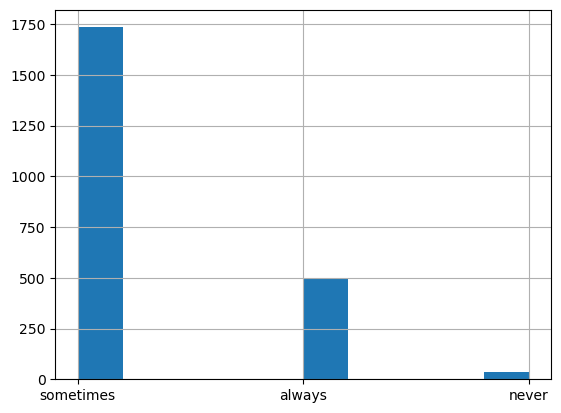

In [199]:
venn_diagram_df["classification"].hist()

In [133]:
venn_diagram_df.head()

,object,classification,pct_right,number_usages,number_of_languages
0,Toyota,sometimes,94.0,427,20
1,Google,sometimes,92.0,836,20
2,Beijing,sometimes,95.0,375,20
3,Dutch,sometimes,77.0,1612,19
4,Vienna,sometimes,94.0,1381,20


In [134]:
venn_diagram_df[venn_diagram_df["classification"] == "sometimes"][
    "pct_right"
].describe()

count    1734.000000
mean       72.301615
std        24.202517
min         5.000000
25%        61.000000
50%        81.000000
75%        91.000000
max       100.000000
Name: pct_right, dtype: float64

In [209]:
venn_diagram_df[venn_diagram_df["classification"] == "sometimes"].sort_values('pct_right')

,object,classification,pct_right,number_usages,number_of_languages
547,SVT2,sometimes,5.0,19,19
370,Ghostface,sometimes,5.0,19,19
606,self-portrait,sometimes,5.0,20,20
655,Opel,sometimes,6.0,17,17
583,Edsel,sometimes,6.0,17,17
...,...,...,...,...,...
233,Konami,sometimes,99.0,204,20
278,Mecca,sometimes,99.0,89,18
572,Congo,sometimes,99.0,98,20
504,Cairo,sometimes,99.0,182,20


### Somtimes Correct analysis

- almost perfect
- almost imperfect

What objects are mostly correct but just barely aren't 'always' right?

In [135]:
venn_diagram_df[venn_diagram_df["classification"] == "sometimes"].sort_values(
    by="pct_right", ascending=False
).head(5)

,object,classification,pct_right,number_usages,number_of_languages
923,Seoul,sometimes,100.0,249,19
278,Mecca,sometimes,99.0,89,18
49,Bangalore,sometimes,99.0,166,18
493,Colombia,sometimes,99.0,140,14
572,Congo,sometimes,99.0,98,20


In [136]:
venn_diagram_df[
    (venn_diagram_df["classification"] == "sometimes")
    & (venn_diagram_df["pct_right"] >= 95.0)
].shape[0]

159

In [137]:
almost_perfect_objects = venn_diagram_df[
    (venn_diagram_df["classification"] == "sometimes")
    & (venn_diagram_df["pct_right"] >= 95.0)
]["object"]

In [138]:
almost_perfect_objects.shape[0]

159

In [139]:
almost_perfect_rows = []
for e in almost_perfect_objects:
    rows = get_rows_by_object(e)
    almost_perfect_rows.append(rows)

almost_perfect_rows = pd.concat(almost_perfect_rows, axis=0)

english_objects = []
for d_id in list(almost_perfect_rows.dataset_id):
    english_objects.append(dataset_id_to_eng_object[d_id])

almost_perfect_rows["english_object"] = english_objects

In [140]:
almost_perfect_rows.shape

(1025, 14)

In [141]:
almost_perfect_rows.head()

,dataset_id,stem,true,false,relation,subject,object,correct,language,lang_code,relation_title,analysis_id,object_en,english_object
2785,calinet_2841,Главни град ЦХН је,Пекинг,Ирачка влада <br> Спартанбург <br> Цервера <br...,P36,ЦХН,Пекинг,False,Serbian,sr,capital,2786,Beijing,Beijing
1361,rome_17921,"Qing-dinasztia, amelynek fővárosa",Peking,Párizs,P36,Csing dinasztia,Peking,False,Hungarian,hu,capital,58872,Beijing,Beijing
3947,rome_12771,Friedrich Rosen va morir a,Pequín,Londres,P20,Friedrich Rosen,Pequín,False,Catalan,ca,place of death,66108,Beijing,Beijing
2725,rome_17921,"Dynastia Qing, której stolicą jest",Pekin,Paryż,P36,Dynastia Qing,Pekin,False,Polish,pl,capital,83784,Beijing,Beijing
3923,rome_10058,Джоу Лонг беше от <br> Джоу Лонг беше родом от,Пекин,Единбург,P19,Zhou Long,Пекин,False,Bulgarian,bg,place of birth,97755,Beijing,Beijing


In [142]:
# write to csv
# ../../data/error_analysis/almost_perfect_objects.csv
almost_perfect_rows.to_csv(
    "../../data/error_analysis/object_analysis_almost_perfect_objects.csv", index=False
)

What objects are mostly wrong but just barely aren't 'never' right

In [200]:
venn_diagram_df[
    (venn_diagram_df["classification"] == "sometimes")
    & (venn_diagram_df["pct_right"] <= 5.0)
]

,object,classification,pct_right,number_usages,number_of_languages
370,Ghostface,sometimes,5.0,19,19
547,SVT2,sometimes,5.0,19,19
606,self-portrait,sometimes,5.0,20,20


In [144]:
almost_imperfect_objects = venn_diagram_df[
    (venn_diagram_df["classification"] == "sometimes")
    & (venn_diagram_df["pct_right"] <= 5.0)
]["object"]

In [145]:
almost_imperfect_rows = []
for e in almost_imperfect_objects:
    rows = get_rows_by_object(e)
    almost_imperfect_rows.append(rows)

almost_imperfect_rows = pd.concat(almost_imperfect_rows, axis=0)

english_objects = []
for d_id in list(almost_imperfect_rows.dataset_id):
    english_objects.append(dataset_id_to_eng_object[d_id])

almost_imperfect_rows["english_object"] = english_objects

In [146]:
almost_imperfect_rows.shape

(55, 14)

In [147]:
almost_imperfect_rows.to_csv(
    "../../data/error_analysis/object_analysis_almost_imperfect_objects.csv",
    index=False,
)

### Check for Correlations

In [148]:
almost_imperfect_objects = venn_diagram_df[
    (venn_diagram_df["classification"] == "sometimes")
    & (venn_diagram_df["pct_right"] <= 5.0)
]["object"]

Is there a correlation between the number of times an object appears and how accurate it is?

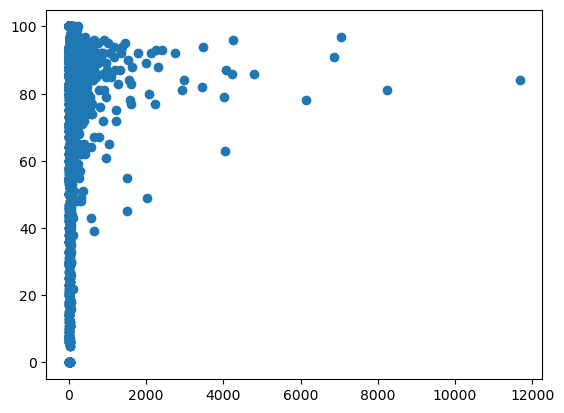

In [149]:
plt.scatter(venn_diagram_df["number_usages"], venn_diagram_df["pct_right"])
plt.show()

No

In [150]:
venn_diagram_df["number_usages"].corr(venn_diagram_df["pct_right"])

0.04939541834289125

Is there a correlation between the number of langs an object appears and how accurate it is?

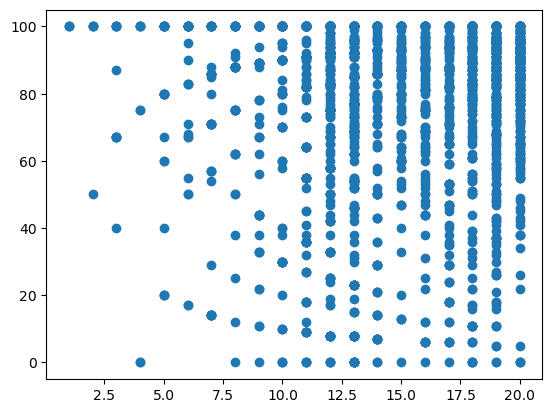

In [151]:
plt.scatter(venn_diagram_df["number_of_languages"], venn_diagram_df["pct_right"])
plt.show()

No

In [152]:
venn_diagram_df["number_of_languages"].corr(venn_diagram_df["pct_right"])

0.05032166422586567